<a href="https://colab.research.google.com/github/HanseulJo/LARS_GradClip/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Run

## Dependency

In [1]:
!pip install torch_optimizer


In [2]:
import os
import sys
import time
import random
from easydict import EasyDict
from tqdm.notebook import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch_optimizer as opt

## Models

In [3]:
def CBA(in_ch, out_ch, kernel_size=3, padding=0, bn=False, pool=False):
    """
    Conv - (BN) - ReLU(Activation) - (Pool) Block
    """
    layers = [
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
    ]
    if bn:
        layers.insert(1, nn.BatchNorm2d(out_ch))
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))
    return nn.Sequential(*layers)

class ConvNet(nn.Module):
    """
    Simple Convolutional Neural Network for MNIST
    """
    def __init__(self, in_ch=1, out_ch=10, d=10):
        super(ConvNet, self).__init__()
        self.cba1 = CBA(in_ch, d, kernel_size=5, pool=True)
        self.cba2 = CBA(d, d*2, kernel_size=5, pool=True)
        self.fc1 = nn.Linear(d*32, 100)
        self.fc2 = nn.Linear(100, out_ch)

    def forward(self, x):
        # x: N(batchsize) * 1 * 28 * 28
        x = self.cba1(x)    # CBA1 : N * 10 * 24 * 24 -> Pool : N * 10 * 12 * 12
        x = self.cba2(x)    # CBA2 : N * 20 *  8 *  8 -> Pool : N * 20 * 4 * 4
        x = torch.flatten(x, start_dim=1)   # Flat : N * 1280
        x = F.relu(self.fc1(x))             # Lin1 : N * 100
        output = self.fc2(x)                # Lin2 : N * 10
        return output


## Training Function

In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss, train_acc = 0, 0
    data_size = 0
    total_data_size = len(train_loader)
    pbar = enumerate(train_loader)
    if args.verbose:
        pbar = tqdm(pbar, desc=f'TRAIN epoch{epoch} loss?.??? acc?.???', total=total_data_size)
    for batch_idx, (data, target) in pbar:
        data, target = data.to(device), target.to(device)
        data_size += data.size(0)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)  # reduction = 'mean'
        if loss.isnan():
            raise ValueError("NAN Loss")
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
        pred = output.argmax(dim=1, keepdim=True) 
        correct = pred.eq(target.view_as(pred)).sum().item()
        train_acc += correct
        if args.verbose:
            pbar.set_description(f'TRAIN epoch{epoch} loss{loss.item():.3f} acc{100*correct/data.size(0):.3f}')
    
    train_loss /= data_size
    accuracy = 100. * train_acc / data_size
    if args.verbose:
        print(f"Train epoch{epoch} Average Loss: {train_loss:.4f}, Accuracy: {train_acc}/{data_size} ({accuracy:.4f}%)")
    
    return train_loss, accuracy

## Testing Function

In [5]:
def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss, test_acc = 0, 0
    data_size = 0

    with torch.no_grad():
        for data, target in test_loader:
            data_size += data.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')  # sum up batch loss
            if loss.isnan():
                raise ValueError("NAN Loss")
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= data_size
    accuracy = 100. * test_acc / data_size
    if args.verbose:
        print(f"Test  epoch{epoch} Average Loss: {test_loss:.4f}, Accuracy: {test_acc}/{data_size} ({accuracy:.4f}%)")

    return test_loss, accuracy

## Learning Rate Decay (Polynomial)

In [6]:
def poly_decay(epoch, max_epoch, lr_init, lr_final=None, degree=2):
    if degree <= 0:
        assert degree == 0
        return 1
    if lr_final is None:
        lr_final = lr_init * 1e-5
    lr = lr_final + (lr_init - lr_final) * (1 - epoch/max_epoch) ** degree
    return lr / lr_init

## Optimizers

In [7]:
class LARS(Optimizer):
    def __init__(self, params, lr=required, momentum=0, weight_decay=0, eta=0.01, **kwargs):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if eta < 0.0:
            raise ValueError("Invalid LARS coefficient value: {}".format(eta))

        defaults = dict(lr=lr, momentum=momentum,
                        weight_decay=weight_decay, eta=eta)
        super(LARS, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            eta = group['eta']
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                weight_norm = torch.norm(p.data)
                grad_norm = torch.norm(d_p.data)
                
                if weight_decay != 0:
                    grad_norm.add_(weight_norm, alpha=weight_decay)
                    d_p.add_(p.data, alpha=weight_decay)
                # Compute local learning rate for this layer
                local_lr = eta * weight_norm / (grad_norm + 1e-8)
                # Update the momentum term
                actual_lr = local_lr * lr

                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                else:
                    buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=actual_lr)
                p.data.add_(-buf)

        return loss

## Main Function

In [8]:
# It assumes predefined parameters: dataset_train, dataset_test

def main(args, optimizer, device, model):
    
    if args.verbose:
        print(args)

    # Random Seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

    # DataLoader Settings
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if torch.cuda.is_available():
        cuda_kwargs = {'num_workers': 1,
                        'pin_memory': True,
                        'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    
    # DataLoaders
    train_loader = DataLoader(dataset_train, **train_kwargs)
    test_loader = DataLoader(dataset_test, **test_kwargs)

    # LR scheduler (Polynomial Decay)
    scheduler = lr_scheduler.LambdaLR(optimizer,
                                      lr_lambda=lambda x: poly_decay(x, args.epochs, args.lr, 
                                                                     degree=args.lr_decay_degree))
    
    losses = {'train': [],'test': []}
    accuracies = {'train': [],'test': []}
    domain_length = 0
    
    try:
        t_start = time.time()
        epoch_iter = range(1, args.epochs + 1)
        if not args.verbose: # hyperparameter tuning을 할 때의 옵션
            epoch_iter = tqdm(epoch_iter, desc=f'BS{args.batch_size} LRinit{args.lr:.4f} LRdecay{args.lr_decay_degree:2d} ETA{args.eta:.4f} CLIP{args.clip:.4f}')
        for epoch in epoch_iter:
            if args.verbose:
                print(f"LR is modified to {scheduler.get_last_lr()[0]:.4f}")
            tr_l, tr_a = train(args, model, device, train_loader, optimizer, epoch)
            losses['train'].append(tr_l)
            accuracies['train'].append(tr_a)
            te_l, te_a = test(args, model, device, test_loader, epoch)
            losses['test'].append(te_l)
            accuracies['test'].append(te_a)
            domain_length += 1
            scheduler.step()
            if args.dry_run:
                break
            if args.verbose:
                print("-"*70)
        t_train = time.time() - t_start
        if args.verbose:
            print(f"Training Time Lapse: {t_train:.4f} seconds\n")
    except Exception as e:
        print("!!! Exception occured !!!")
        print(e)
        print("\n")
    
    if domain_length > 0 and not args.dry_run and args.verbose:
        fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10,6))
        fig.suptitle(f"batchsize{args.batch_size} lr_init{args.lr} eta{args.eta} gradclip{args.clip}")
        # Train Loss (ax00)
        ax00.plot(list(range(1, domain_length+1)), losses['train'])
        ax00.set_title(f"Train Loss")
        # Train Accuracy (ax01)
        ax01.plot(list(range(1, domain_length+1)), accuracies['train'], color='tab:orange')
        ax01.set_title(f"Train Accuracy")
        # Test Loss (ax10)
        ax10.plot(list(range(1, domain_length+1)), losses['test'], color='tab:green')
        ax10.set_title(f"Test Loss")
        # Test Accuracy (ax11)
        ax11.plot(list(range(1, domain_length+1)), accuracies['test'], color='tab:red')
        ax11.set_title(f"Test Accuracy")
        # Show
        #fig.tight_layout()
        plt.show()
    
    best_test_acc = max(accuracies['test'])

    if args.save_model:
        torch.save(model.state_dict(), "mnist.pt")
    
    return best_test_acc

## Settings

Args, Device, Transform, Dataset/Dataloader, 

In [9]:
# Arguments
args = EasyDict()

args.epochs = 3
args.batch_size = 1000
args.test_batch_size = 10000
args.lr = 0.01
args.lr_decay_degree = 0
args.momentum = 0.
args.weight_decay = 0.
args.eta = 0.001
args.clip = 1.
args.seed = 1

args.dry_run = False
args.save_model = False
args.verbose = True  # True: single run / False: hyperparam tuning

In [10]:
# Device Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
# Transform
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [12]:
# Datasets (If you use GPU, it will take <= 10 min)
dataset_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST('./data', train=False, transform=transform)
print(len(dataset_train))
print(len(dataset_test))

60000
10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Change Optimizer and Train!

In [16]:
# Manipulate Arguments
args = EasyDict()

args.epochs = 10
args.batch_size = 1000
args.test_batch_size = 10000
args.lr = 0.01
args.lr_decay_degree = 0
args.momentum = 0.
args.weight_decay = 0.
args.eta = 0.001
args.clip = 1.
args.seed = 1

args.dry_run = False
args.save_model = False
args.verbose = True

{'epochs': 10, 'batch_size': 200, 'test_batch_size': 10000, 'lr': 0.1, 'lr_decay_degree': 0, 'momentum': 0.0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.1000


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch1 Average Loss: 0.3786, Accuracy: 53020/60000 (88.3667%)
Test  epoch1 Average Loss: 0.0877, Accuracy: 9724/10000 (97.2400%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch2 Average Loss: 0.0818, Accuracy: 58493/60000 (97.4883%)
Test  epoch2 Average Loss: 0.0595, Accuracy: 9798/10000 (97.9800%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch3 Average Loss: 0.0591, Accuracy: 58876/60000 (98.1267%)
Test  epoch3 Average Loss: 0.0462, Accuracy: 9846/10000 (98.4600%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch4 Average Loss: 0.0464, Accuracy: 59105/60000 (98.5083%)
Test  epoch4 Average Loss: 0.0431, Accuracy: 9869/10000 (98.6900%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.0376, Accuracy: 59287/60000 (98.8117%)
Test  epoch5 Average Loss: 0.0360, Accuracy: 9881/10000 (98.8100%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.0333, Accuracy: 59368/60000 (98.9467%)
Test  epoch6 Average Loss: 0.0355, Accuracy: 9884/10000 (98.8400%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.0282, Accuracy: 59474/60000 (99.1233%)
Test  epoch7 Average Loss: 0.0314, Accuracy: 9905/10000 (99.0500%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.0251, Accuracy: 59503/60000 (99.1717%)
Test  epoch8 Average Loss: 0.0330, Accuracy: 9897/10000 (98.9700%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.0225, Accuracy: 59589/60000 (99.3150%)
Test  epoch9 Average Loss: 0.0275, Accuracy: 9908/10000 (99.0800%)
----------------------------------------------------------------------
LR is modified to 0.1000


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/300 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.0195, Accuracy: 59625/60000 (99.3750%)
Test  epoch10 Average Loss: 0.0285, Accuracy: 9907/10000 (99.0700%)
----------------------------------------------------------------------
Training Time Lapse: 111.5048 seconds



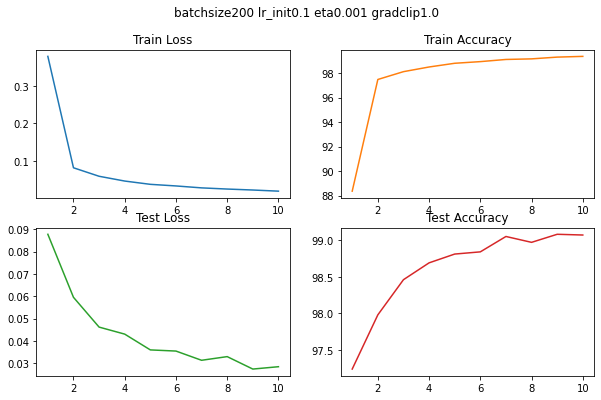

In [20]:
# Vanilla SGD, Benchmark(batchsize 200, lr 0.1)
args.update(epochs=10, batch_size=200, lr=0.1)
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.055, 'lr_decay_degree': 0, 'momentum': 0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.0550


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.3003, Accuracy: 7682/60000 (12.8033%)
Test  epoch1 Average Loss: 2.2854, Accuracy: 1918/10000 (19.1800%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 2.2782, Accuracy: 12937/60000 (21.5617%)
Test  epoch2 Average Loss: 2.2629, Accuracy: 2687/10000 (26.8700%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 2.2552, Accuracy: 18011/60000 (30.0183%)
Test  epoch3 Average Loss: 2.2362, Accuracy: 3646/10000 (36.4600%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 2.2265, Accuracy: 23759/60000 (39.5983%)
Test  epoch4 Average Loss: 2.2006, Accuracy: 4649/10000 (46.4900%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 2.1873, Accuracy: 28905/60000 (48.1750%)
Test  epoch5 Average Loss: 2.1496, Accuracy: 5322/10000 (53.2200%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 2.1302, Accuracy: 32297/60000 (53.8283%)
Test  epoch6 Average Loss: 2.0738, Accuracy: 5778/10000 (57.7800%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 2.0440, Accuracy: 35535/60000 (59.2250%)
Test  epoch7 Average Loss: 1.9557, Accuracy: 6360/10000 (63.6000%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 1.9074, Accuracy: 38855/60000 (64.7583%)
Test  epoch8 Average Loss: 1.7674, Accuracy: 6735/10000 (67.3500%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 1.6944, Accuracy: 41087/60000 (68.4783%)
Test  epoch9 Average Loss: 1.4932, Accuracy: 7171/10000 (71.7100%)
----------------------------------------------------------------------
LR is modified to 0.0550


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 1.4096, Accuracy: 43123/60000 (71.8717%)
Test  epoch10 Average Loss: 1.2138, Accuracy: 7202/10000 (72.0200%)
----------------------------------------------------------------------
Training Time Lapse: 147.9017 seconds



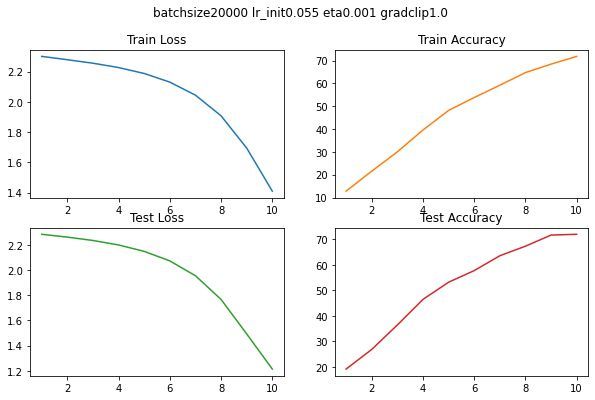

In [48]:
# vanilla SGD
args.update(epochs=10, batch_size=20000, lr=0.055)
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.15, 'lr_decay_degree': 2, 'momentum': 0.0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.1500


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.2881, Accuracy: 10743/60000 (17.9050%)
Test  epoch1 Average Loss: 2.2477, Accuracy: 3286/10000 (32.8600%)
----------------------------------------------------------------------
LR is modified to 0.1215


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 2.2269, Accuracy: 23746/60000 (39.5767%)
Test  epoch2 Average Loss: 2.1690, Accuracy: 5154/10000 (51.5400%)
----------------------------------------------------------------------
LR is modified to 0.0960


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 2.1363, Accuracy: 31761/60000 (52.9350%)
Test  epoch3 Average Loss: 2.0405, Accuracy: 6102/10000 (61.0200%)
----------------------------------------------------------------------
LR is modified to 0.0735


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 1.9908, Accuracy: 37657/60000 (62.7617%)
Test  epoch4 Average Loss: 1.8450, Accuracy: 6533/10000 (65.3300%)
----------------------------------------------------------------------
LR is modified to 0.0540


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 1.7833, Accuracy: 40119/60000 (66.8650%)
Test  epoch5 Average Loss: 1.6082, Accuracy: 6905/10000 (69.0500%)
----------------------------------------------------------------------
LR is modified to 0.0375


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 1.5559, Accuracy: 41979/60000 (69.9650%)
Test  epoch6 Average Loss: 1.4003, Accuracy: 7333/10000 (73.3300%)
----------------------------------------------------------------------
LR is modified to 0.0240


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 1.3738, Accuracy: 43680/60000 (72.8000%)
Test  epoch7 Average Loss: 1.2631, Accuracy: 7468/10000 (74.6800%)
----------------------------------------------------------------------
LR is modified to 0.0135


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 1.2595, Accuracy: 44557/60000 (74.2617%)
Test  epoch8 Average Loss: 1.1883, Accuracy: 7552/10000 (75.5200%)
----------------------------------------------------------------------
LR is modified to 0.0060


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 1.2000, Accuracy: 45008/60000 (75.0133%)
Test  epoch9 Average Loss: 1.1561, Accuracy: 7613/10000 (76.1300%)
----------------------------------------------------------------------
LR is modified to 0.0015


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 1.1763, Accuracy: 45241/60000 (75.4017%)
Test  epoch10 Average Loss: 1.1481, Accuracy: 7622/10000 (76.2200%)
----------------------------------------------------------------------
Training Time Lapse: 139.3940 seconds



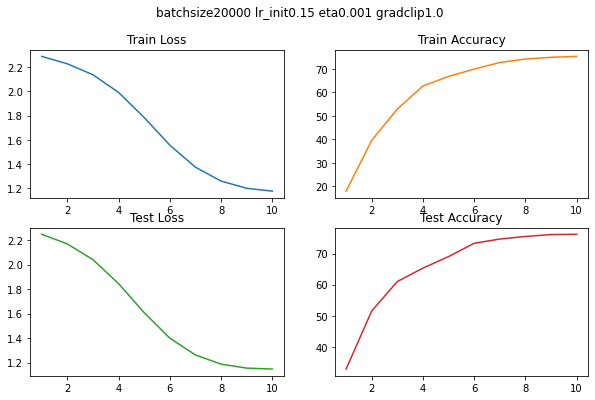

In [23]:
# vanilla SGD with 2nd polynomial LR decay
args.update(epochs=10, batch_size=20000, lr=0.15, lr_decay_degree=2)
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.015, 'lr_decay_degree': 0, 'momentum': 0.9, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.0150


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.3053, Accuracy: 6471/60000 (10.7850%)
Test  epoch1 Average Loss: 2.2963, Accuracy: 1434/10000 (14.3400%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 2.2889, Accuracy: 10452/60000 (17.4200%)
Test  epoch2 Average Loss: 2.2724, Accuracy: 2423/10000 (24.2300%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 2.2631, Accuracy: 16759/60000 (27.9317%)
Test  epoch3 Average Loss: 2.2411, Accuracy: 3851/10000 (38.5100%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 2.2291, Accuracy: 25712/60000 (42.8533%)
Test  epoch4 Average Loss: 2.1972, Accuracy: 5064/10000 (50.6400%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 2.1786, Accuracy: 30911/60000 (51.5183%)
Test  epoch5 Average Loss: 2.1259, Accuracy: 5493/10000 (54.9300%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 2.0950, Accuracy: 33200/60000 (55.3333%)
Test  epoch6 Average Loss: 2.0049, Accuracy: 5850/10000 (58.5000%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 1.9492, Accuracy: 36379/60000 (60.6317%)
Test  epoch7 Average Loss: 1.7847, Accuracy: 6525/10000 (65.2500%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 1.6849, Accuracy: 40135/60000 (66.8917%)
Test  epoch8 Average Loss: 1.4132, Accuracy: 7150/10000 (71.5000%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 1.2802, Accuracy: 43630/60000 (72.7167%)
Test  epoch9 Average Loss: 0.9592, Accuracy: 7670/10000 (76.7000%)
----------------------------------------------------------------------
LR is modified to 0.0150


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.8680, Accuracy: 46452/60000 (77.4200%)
Test  epoch10 Average Loss: 0.6539, Accuracy: 8017/10000 (80.1700%)
----------------------------------------------------------------------
Training Time Lapse: 143.6416 seconds



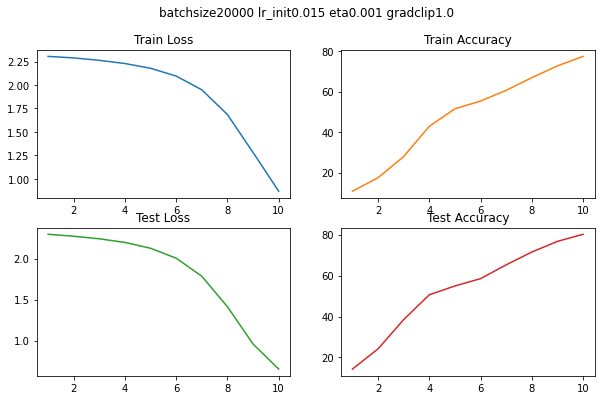

In [31]:
# vanilla SGD with 2nd polynomial LR decay
args.update(epochs=10, batch_size=20000, lr=0.015, lr_decay_degree=0, momentum=0.9)
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.07, 'lr_decay_degree': 2, 'momentum': 0.9, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.0700


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.2957, Accuracy: 8936/60000 (14.8933%)
Test  epoch1 Average Loss: 2.2578, Accuracy: 3026/10000 (30.2600%)
----------------------------------------------------------------------
LR is modified to 0.0567


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 2.2335, Accuracy: 24150/60000 (40.2500%)
Test  epoch2 Average Loss: 2.1597, Accuracy: 5284/10000 (52.8400%)
----------------------------------------------------------------------
LR is modified to 0.0448


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 2.1056, Accuracy: 32222/60000 (53.7033%)
Test  epoch3 Average Loss: 1.9252, Accuracy: 6006/10000 (60.0600%)
----------------------------------------------------------------------
LR is modified to 0.0343


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 1.7965, Accuracy: 38477/60000 (64.1283%)
Test  epoch4 Average Loss: 1.4148, Accuracy: 7033/10000 (70.3300%)
----------------------------------------------------------------------
LR is modified to 0.0252


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 1.2449, Accuracy: 43427/60000 (72.3783%)
Test  epoch5 Average Loss: 0.8559, Accuracy: 7728/10000 (77.2800%)
----------------------------------------------------------------------
LR is modified to 0.0175


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.7879, Accuracy: 46987/60000 (78.3117%)
Test  epoch6 Average Loss: 0.6128, Accuracy: 8063/10000 (80.6300%)
----------------------------------------------------------------------
LR is modified to 0.0112


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.6091, Accuracy: 48615/60000 (81.0250%)
Test  epoch7 Average Loss: 0.5274, Accuracy: 8350/10000 (83.5000%)
----------------------------------------------------------------------
LR is modified to 0.0063


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.5441, Accuracy: 49905/60000 (83.1750%)
Test  epoch8 Average Loss: 0.4977, Accuracy: 8449/10000 (84.4900%)
----------------------------------------------------------------------
LR is modified to 0.0028


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.5161, Accuracy: 50435/60000 (84.0583%)
Test  epoch9 Average Loss: 0.4791, Accuracy: 8529/10000 (85.2900%)
----------------------------------------------------------------------
LR is modified to 0.0007


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.5040, Accuracy: 50733/60000 (84.5550%)
Test  epoch10 Average Loss: 0.4739, Accuracy: 8556/10000 (85.5600%)
----------------------------------------------------------------------
Training Time Lapse: 148.6786 seconds



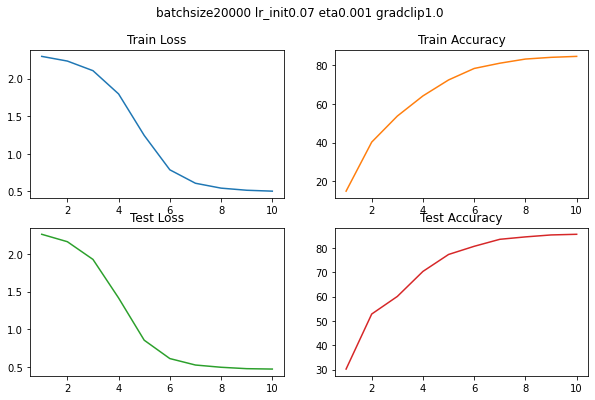

In [36]:
# momentum SGD with 2nd polynomial LR decay
args.update(epochs=10, batch_size=20000, lr=0.07, lr_decay_degree=2, momentum=0.9)
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.01, 'lr_decay_degree': 0, 'momentum': 0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.0100


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.1881, Accuracy: 14006/60000 (23.3433%)
Test  epoch1 Average Loss: 1.6004, Accuracy: 6049/10000 (60.4900%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 1.2639, Accuracy: 38819/60000 (64.6983%)
Test  epoch2 Average Loss: 1.2045, Accuracy: 6597/10000 (65.9700%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 0.9219, Accuracy: 43251/60000 (72.0850%)
Test  epoch3 Average Loss: 0.6432, Accuracy: 7939/10000 (79.3900%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 0.6058, Accuracy: 49051/60000 (81.7517%)
Test  epoch4 Average Loss: 0.4555, Accuracy: 8767/10000 (87.6700%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.4345, Accuracy: 52669/60000 (87.7817%)
Test  epoch5 Average Loss: 0.3292, Accuracy: 9008/10000 (90.0800%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.3266, Accuracy: 53989/60000 (89.9817%)
Test  epoch6 Average Loss: 0.2457, Accuracy: 9310/10000 (93.1000%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.2481, Accuracy: 55639/60000 (92.7317%)
Test  epoch7 Average Loss: 0.2140, Accuracy: 9392/10000 (93.9200%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.2126, Accuracy: 56355/60000 (93.9250%)
Test  epoch8 Average Loss: 0.1727, Accuracy: 9498/10000 (94.9800%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.1768, Accuracy: 56826/60000 (94.7100%)
Test  epoch9 Average Loss: 0.1539, Accuracy: 9538/10000 (95.3800%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.1527, Accuracy: 57220/60000 (95.3667%)
Test  epoch10 Average Loss: 0.1316, Accuracy: 9594/10000 (95.9400%)
----------------------------------------------------------------------
Training Time Lapse: 147.1067 seconds



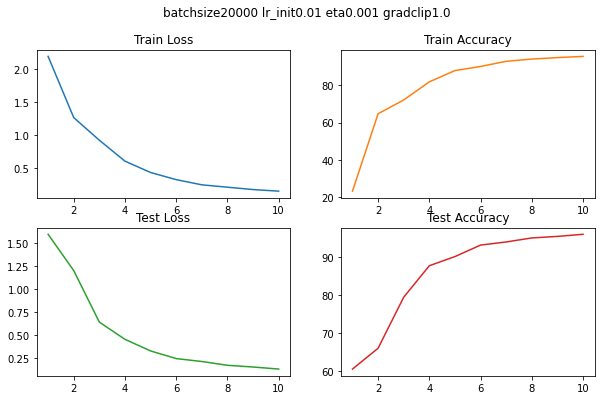

In [44]:
# vanilla ADAM
args.update(epochs=10, batch_size=20000, lr=0.01, lr_decay_degree=0, momentum=0)
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.01, 'lr_decay_degree': 0, 'momentum': 0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': True}
LR is modified to 0.0100


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.1556, Accuracy: 13451/60000 (22.4183%)
Test  epoch1 Average Loss: 1.4429, Accuracy: 6145/10000 (61.4500%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 1.1971, Accuracy: 39550/60000 (65.9167%)
Test  epoch2 Average Loss: 1.0597, Accuracy: 7366/10000 (73.6600%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 0.8102, Accuracy: 45670/60000 (76.1167%)
Test  epoch3 Average Loss: 0.6141, Accuracy: 7941/10000 (79.4100%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 0.5494, Accuracy: 49774/60000 (82.9567%)
Test  epoch4 Average Loss: 0.3905, Accuracy: 8794/10000 (87.9400%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.3822, Accuracy: 53059/60000 (88.4317%)
Test  epoch5 Average Loss: 0.2969, Accuracy: 9142/10000 (91.4200%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.3077, Accuracy: 54878/60000 (91.4633%)
Test  epoch6 Average Loss: 0.2580, Accuracy: 9286/10000 (92.8600%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.2538, Accuracy: 55694/60000 (92.8233%)
Test  epoch7 Average Loss: 0.2016, Accuracy: 9405/10000 (94.0500%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.2086, Accuracy: 56315/60000 (93.8583%)
Test  epoch8 Average Loss: 0.1733, Accuracy: 9461/10000 (94.6100%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.1799, Accuracy: 56766/60000 (94.6100%)
Test  epoch9 Average Loss: 0.1464, Accuracy: 9555/10000 (95.5500%)
----------------------------------------------------------------------
LR is modified to 0.0100


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.1556, Accuracy: 57186/60000 (95.3100%)
Test  epoch10 Average Loss: 0.1319, Accuracy: 9588/10000 (95.8800%)
----------------------------------------------------------------------
Training Time Lapse: 149.3149 seconds



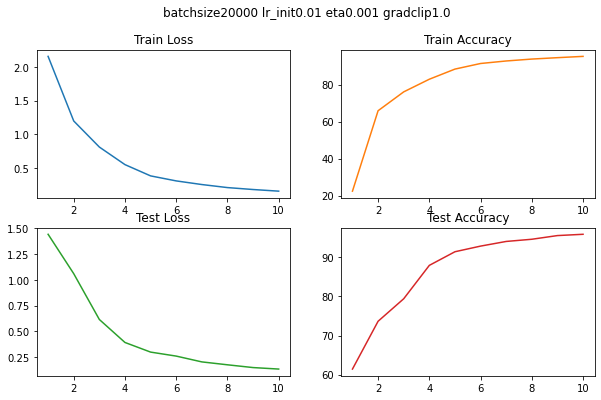

In [51]:
# AdamW
args.update(epochs=10, batch_size=20000, lr=0.01)
model = ConvNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

In [14]:
# LARS, no lr decay
n_iter = 100
result = []

for lr_e, eta_e in (np.random.rand(n_iter, 2)*3-2):
    lr, eta = 10**lr_e, 10**eta_e
    args.update(epochs=10, batch_size=20000, lr=lr, eta=eta, verbose=False)
    model = ConvNet().to(device)
    optimizer = LARS(model.parameters(), lr=args.lr, eta=args.eta, weight_decay=args.weight_decay)
    best_test_acc = main(args, optimizer, device, model)
    print(f"Best Acc {best_test_acc}, LR {lr:.4f}, ETA {eta:.4f}")
    result.append((best_test_acc, lr, eta))

print("-"*100)
result.sort(key=lambda x: -x[0])
for i in range(10):
    print(result[i])

BS20000 LRinit3.9083 LRdecay 0 ETA0.0963 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best Acc 35.1, LR 3.9083, ETA 0.0963


BS20000 LRinit0.8750 LRdecay 0 ETA0.0133 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.68, LR 0.8750, ETA 0.0133


BS20000 LRinit0.0128 LRdecay 0 ETA1.7999 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.38, LR 0.0128, ETA 1.7999


BS20000 LRinit0.0108 LRdecay 0 ETA0.2212 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 58.41, LR 0.0108, ETA 0.2212


BS20000 LRinit0.0271 LRdecay 0 ETA8.4941 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 55.97, LR 0.0271, ETA 8.4941


BS20000 LRinit1.1252 LRdecay 0 ETA3.1845 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 1.1252, ETA 3.1845


BS20000 LRinit1.9487 LRdecay 0 ETA0.1284 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 62.85, LR 1.9487, ETA 0.1284


BS20000 LRinit0.0161 LRdecay 0 ETA0.0570 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 34.8, LR 0.0161, ETA 0.0570


BS20000 LRinit0.0111 LRdecay 0 ETA0.0187 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 15.48, LR 0.0111, ETA 0.0187


BS20000 LRinit0.4577 LRdecay 0 ETA2.8717 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 0.4577, ETA 2.8717


BS20000 LRinit2.4731 LRdecay 0 ETA0.0284 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 81.71, LR 2.4731, ETA 0.0284


BS20000 LRinit0.1495 LRdecay 0 ETA0.0234 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 64.78, LR 0.1495, ETA 0.0234


BS20000 LRinit0.4661 LRdecay 0 ETA0.2984 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 79.78, LR 0.4661, ETA 0.2984


BS20000 LRinit0.0213 LRdecay 0 ETA1.0995 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.16, LR 0.0213, ETA 1.0995


BS20000 LRinit0.5537 LRdecay 0 ETA3.3941 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 0.5537, ETA 3.3941


BS20000 LRinit1.7276 LRdecay 0 ETA0.0311 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 81.07, LR 1.7276, ETA 0.0311


BS20000 LRinit2.5490 LRdecay 0 ETA7.5128 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 10.1, LR 2.5490, ETA 7.5128


BS20000 LRinit0.0201 LRdecay 0 ETA3.3765 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 89.38, LR 0.0201, ETA 3.3765


BS20000 LRinit0.1289 LRdecay 0 ETA0.0156 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 55.55, LR 0.1289, ETA 0.0156


BS20000 LRinit3.1259 LRdecay 0 ETA0.0186 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 81.72, LR 3.1259, ETA 0.0186


BS20000 LRinit5.2049 LRdecay 0 ETA8.9722 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 11.17, LR 5.2049, ETA 8.9722


BS20000 LRinit0.9145 LRdecay 0 ETA0.0224 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.22, LR 0.9145, ETA 0.0224


BS20000 LRinit0.4390 LRdecay 0 ETA1.7875 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 13.25, LR 0.4390, ETA 1.7875


BS20000 LRinit0.1877 LRdecay 0 ETA0.6195 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 87.98, LR 0.1877, ETA 0.6195


BS20000 LRinit0.0269 LRdecay 0 ETA0.1572 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 67.71, LR 0.0269, ETA 0.1572


BS20000 LRinit0.0121 LRdecay 0 ETA0.0772 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 35.17, LR 0.0121, ETA 0.0772


BS20000 LRinit0.8835 LRdecay 0 ETA2.8160 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 10.28, LR 0.8835, ETA 2.8160


BS20000 LRinit0.8204 LRdecay 0 ETA3.3236 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.51, LR 0.8204, ETA 3.3236


BS20000 LRinit0.0477 LRdecay 0 ETA0.0327 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 50.87, LR 0.0477, ETA 0.0327


BS20000 LRinit0.6360 LRdecay 0 ETA2.0516 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 0.6360, ETA 2.0516


BS20000 LRinit0.5156 LRdecay 0 ETA7.2782 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 0.5156, ETA 7.2782


BS20000 LRinit0.1132 LRdecay 0 ETA0.2266 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.33, LR 0.1132, ETA 0.2266


BS20000 LRinit0.0116 LRdecay 0 ETA0.2659 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 62.76, LR 0.0116, ETA 0.2659


BS20000 LRinit0.0109 LRdecay 0 ETA0.0931 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 37.62, LR 0.0109, ETA 0.0931


BS20000 LRinit0.0274 LRdecay 0 ETA0.6533 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.22, LR 0.0274, ETA 0.6533


BS20000 LRinit0.1440 LRdecay 0 ETA0.5216 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.07, LR 0.1440, ETA 0.5216


BS20000 LRinit3.6956 LRdecay 0 ETA0.7908 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 3.6956, ETA 0.7908


BS20000 LRinit0.0244 LRdecay 0 ETA0.3179 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 77.77, LR 0.0244, ETA 0.3179


BS20000 LRinit0.0154 LRdecay 0 ETA1.8023 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 77.51, LR 0.0154, ETA 1.8023


BS20000 LRinit0.0193 LRdecay 0 ETA0.2002 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 66.35, LR 0.0193, ETA 0.2002


BS20000 LRinit0.0104 LRdecay 0 ETA0.0260 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 17.51, LR 0.0104, ETA 0.0260


BS20000 LRinit0.0237 LRdecay 0 ETA0.2014 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 69.51, LR 0.0237, ETA 0.2014


BS20000 LRinit0.1030 LRdecay 0 ETA0.4923 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 80.13, LR 0.1030, ETA 0.4923


BS20000 LRinit1.0050 LRdecay 0 ETA0.0104 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.87, LR 1.0050, ETA 0.0104


BS20000 LRinit1.5046 LRdecay 0 ETA0.0626 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.7, LR 1.5046, ETA 0.0626


BS20000 LRinit1.5904 LRdecay 0 ETA0.0832 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 79.22, LR 1.5904, ETA 0.0832


BS20000 LRinit0.1457 LRdecay 0 ETA0.0228 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 63.83, LR 0.1457, ETA 0.0228


BS20000 LRinit0.3364 LRdecay 0 ETA1.1382 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 20.14, LR 0.3364, ETA 1.1382


BS20000 LRinit3.1951 LRdecay 0 ETA0.0163 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 82.08, LR 3.1951, ETA 0.0163


BS20000 LRinit0.3223 LRdecay 0 ETA0.3666 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 82.16, LR 0.3223, ETA 0.3666


BS20000 LRinit4.3484 LRdecay 0 ETA0.2166 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.88, LR 4.3484, ETA 0.2166


BS20000 LRinit0.0129 LRdecay 0 ETA0.6114 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 77.84, LR 0.0129, ETA 0.6114


BS20000 LRinit0.0120 LRdecay 0 ETA1.0025 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.64, LR 0.0120, ETA 1.0025


BS20000 LRinit0.4159 LRdecay 0 ETA0.0359 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.73, LR 0.4159, ETA 0.0359


BS20000 LRinit0.0330 LRdecay 0 ETA1.2124 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 79.46, LR 0.0330, ETA 1.2124


BS20000 LRinit0.1794 LRdecay 0 ETA0.0671 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.6, LR 0.1794, ETA 0.0671


BS20000 LRinit0.0439 LRdecay 0 ETA7.8369 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 25.16, LR 0.0439, ETA 7.8369


BS20000 LRinit8.3013 LRdecay 0 ETA1.2598 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 11.35, LR 8.3013, ETA 1.2598


BS20000 LRinit1.2612 LRdecay 0 ETA0.6809 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 14.81, LR 1.2612, ETA 0.6809


BS20000 LRinit2.4426 LRdecay 0 ETA0.3078 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 2.4426, ETA 0.3078


BS20000 LRinit0.0987 LRdecay 0 ETA0.0138 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 47.03, LR 0.0987, ETA 0.0138


BS20000 LRinit1.4368 LRdecay 0 ETA1.0904 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 13.85, LR 1.4368, ETA 1.0904


BS20000 LRinit2.7697 LRdecay 0 ETA0.8282 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 10.28, LR 2.7697, ETA 0.8282


BS20000 LRinit1.8402 LRdecay 0 ETA0.0222 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 81.85, LR 1.8402, ETA 0.0222


BS20000 LRinit0.0372 LRdecay 0 ETA5.9239 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 62.65, LR 0.0372, ETA 5.9239


BS20000 LRinit0.5155 LRdecay 0 ETA0.0924 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.13, LR 0.5155, ETA 0.0924


BS20000 LRinit1.4485 LRdecay 0 ETA0.2144 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 44.24, LR 1.4485, ETA 0.2144


BS20000 LRinit3.3753 LRdecay 0 ETA0.1413 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 28.14, LR 3.3753, ETA 0.1413


BS20000 LRinit0.0926 LRdecay 0 ETA0.0433 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 66.86, LR 0.0926, ETA 0.0433


BS20000 LRinit0.0130 LRdecay 0 ETA1.6325 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.81, LR 0.0130, ETA 1.6325


BS20000 LRinit1.1965 LRdecay 0 ETA1.4699 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 1.1965, ETA 1.4699


BS20000 LRinit0.1133 LRdecay 0 ETA2.7207 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 53.38, LR 0.1133, ETA 2.7207


BS20000 LRinit0.0795 LRdecay 0 ETA0.2659 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 76.29, LR 0.0795, ETA 0.2659


BS20000 LRinit0.0224 LRdecay 0 ETA0.0444 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 37.03, LR 0.0224, ETA 0.0444


BS20000 LRinit4.9800 LRdecay 0 ETA0.0202 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 82.37, LR 4.9800, ETA 0.0202


BS20000 LRinit7.7484 LRdecay 0 ETA6.6082 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 11.35, LR 7.7484, ETA 6.6082


BS20000 LRinit5.9615 LRdecay 0 ETA7.3792 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 10.28, LR 5.9615, ETA 7.3792


BS20000 LRinit0.0748 LRdecay 0 ETA2.9915 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 64.92, LR 0.0748, ETA 2.9915


BS20000 LRinit0.0734 LRdecay 0 ETA0.0112 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 31.78, LR 0.0734, ETA 0.0112


BS20000 LRinit0.2142 LRdecay 0 ETA4.6302 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 15.06, LR 0.2142, ETA 4.6302


BS20000 LRinit0.0105 LRdecay 0 ETA0.0158 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 14.23, LR 0.0105, ETA 0.0158


BS20000 LRinit7.4828 LRdecay 0 ETA0.0676 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 15.09, LR 7.4828, ETA 0.0676


BS20000 LRinit0.1235 LRdecay 0 ETA0.0283 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 64.77, LR 0.1235, ETA 0.0283


BS20000 LRinit0.0171 LRdecay 0 ETA0.1491 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 59.46, LR 0.0171, ETA 0.1491


BS20000 LRinit1.7515 LRdecay 0 ETA1.7650 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 1.7515, ETA 1.7650


BS20000 LRinit0.0755 LRdecay 0 ETA1.5247 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.24, LR 0.0755, ETA 1.5247


BS20000 LRinit0.2679 LRdecay 0 ETA0.0887 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.15, LR 0.2679, ETA 0.0887


BS20000 LRinit8.5868 LRdecay 0 ETA1.7195 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

!!! Exception occured !!!
NAN Loss


Best Acc 10.28, LR 8.5868, ETA 1.7195


BS20000 LRinit0.0776 LRdecay 0 ETA0.9839 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.59, LR 0.0776, ETA 0.9839


BS20000 LRinit0.0790 LRdecay 0 ETA1.9212 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 83.25, LR 0.0790, ETA 1.9212


BS20000 LRinit0.4290 LRdecay 0 ETA1.6263 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 17.17, LR 0.4290, ETA 1.6263


BS20000 LRinit0.0409 LRdecay 0 ETA2.7716 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.86, LR 0.0409, ETA 2.7716


BS20000 LRinit0.4696 LRdecay 0 ETA0.3521 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 82.16, LR 0.4696, ETA 0.3521


BS20000 LRinit0.0765 LRdecay 0 ETA0.4626 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 79.65, LR 0.0765, ETA 0.4626


BS20000 LRinit1.6657 LRdecay 0 ETA2.3110 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 11.35, LR 1.6657, ETA 2.3110


BS20000 LRinit3.6411 LRdecay 0 ETA0.2019 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 18.35, LR 3.6411, ETA 0.2019


BS20000 LRinit0.1288 LRdecay 0 ETA0.4860 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 84.03, LR 0.1288, ETA 0.4860


BS20000 LRinit0.1088 LRdecay 0 ETA0.3388 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 79.07, LR 0.1088, ETA 0.3388


BS20000 LRinit0.1279 LRdecay 0 ETA0.5104 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 85.53, LR 0.1279, ETA 0.5104


BS20000 LRinit0.0242 LRdecay 0 ETA7.1656 CLIP1.0000:   0%|          | 0/10 [00:00<?, ?it/s]

Best Acc 75.71, LR 0.0242, ETA 7.1656
----------------------------------------------------------------------------------------------------
(89.38, 0.02008959917164093, 3.3765472485018146)
(87.98, 0.18767304847208816, 0.619518687902507)
(85.53, 0.12787031717098205, 0.5103891766159654)
(84.86, 0.04088392469241108, 2.77163929934243)
(84.7, 1.5046265905371843, 0.06261683685563404)
(84.59, 0.07762458166009426, 0.9839389627602375)
(84.24, 0.07554860927593506, 1.5247035771451583)
(84.13, 0.5155124470205966, 0.0923593347807005)
(84.07, 0.1440104137356331, 0.5216322303111169)
(84.03, 0.12881278449965997, 0.48596590816557717)


In [ ]:
# LARS with lr decay
n_iter = 100
result = []

for lr_e, eta_e in (np.random.rand(n_iter, 2)*3-2):
    lr, eta = 10**lr_e, 10**eta_e
    args.update(epochs=10, batch_size=20000, lr=lr, eta=eta, verbose=False, lr_decay_degree=2)
    model = ConvNet().to(device)
    optimizer = LARS(model.parameters(), lr=args.lr, eta=args.eta, weight_decay=args.weight_decay)
    best_test_acc = main(args, optimizer, device, model)
    print(f"Best Acc {best_test_acc}, LR {lr:.4f}, ETA {eta:.4f}")
    result.append((best_test_acc, lr, eta))

print("-"*100)
result.sort(key=lambda x: -x[0])
for i in range(10):
    print(result[i])

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.025, 'lr_decay_degree': 0, 'momentum': 0.0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': False, 'verbose': True}
LR is modified to 0.0250


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.2687, Accuracy: 16346/60000 (27.2433%)
Test  epoch1 Average Loss: 2.1770, Accuracy: 5593/10000 (55.9300%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 2.1109, Accuracy: 33270/60000 (55.4500%)
Test  epoch2 Average Loss: 1.9306, Accuracy: 5887/10000 (58.8700%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 1.8119, Accuracy: 37245/60000 (62.0750%)
Test  epoch3 Average Loss: 1.5082, Accuracy: 7284/10000 (72.8400%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 1.3597, Accuracy: 45229/60000 (75.3817%)
Test  epoch4 Average Loss: 1.0149, Accuracy: 7835/10000 (78.3500%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.9067, Accuracy: 47311/60000 (78.8517%)
Test  epoch5 Average Loss: 0.6509, Accuracy: 8276/10000 (82.7600%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.6057, Accuracy: 49801/60000 (83.0017%)
Test  epoch6 Average Loss: 0.4644, Accuracy: 8580/10000 (85.8000%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.4659, Accuracy: 51514/60000 (85.8567%)
Test  epoch7 Average Loss: 0.4361, Accuracy: 8637/10000 (86.3700%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.4785, Accuracy: 51426/60000 (85.7100%)
Test  epoch8 Average Loss: 0.4284, Accuracy: 8805/10000 (88.0500%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.5060, Accuracy: 51870/60000 (86.4500%)
Test  epoch9 Average Loss: 0.4734, Accuracy: 8709/10000 (87.0900%)
----------------------------------------------------------------------
LR is modified to 0.0250


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.4611, Accuracy: 52555/60000 (87.5917%)
Test  epoch10 Average Loss: 0.3397, Accuracy: 9094/10000 (90.9400%)
----------------------------------------------------------------------
Training Time Lapse: 86.3091 seconds



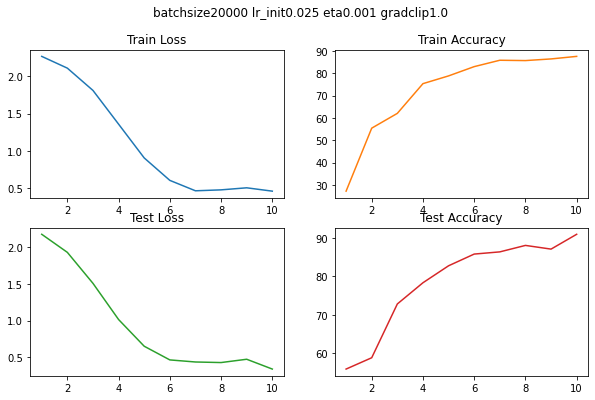

90.94

In [21]:
args.update(epochs=10, batch_size=20000, lr=0.025, verbose=True, lr_decay_degree=0)
model = ConvNet().to(device)
optimizer = opt.Lamb(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.2, 'lr_decay_degree': 2, 'momentum': 0.0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': False, 'verbose': True}
LR is modified to 0.2000


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.1588, Accuracy: 12129/60000 (20.2150%)
Test  epoch1 Average Loss: 1.6152, Accuracy: 4200/10000 (42.0000%)
----------------------------------------------------------------------
LR is modified to 0.1620


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 1.3580, Accuracy: 33353/60000 (55.5883%)
Test  epoch2 Average Loss: 1.2249, Accuracy: 6956/10000 (69.5600%)
----------------------------------------------------------------------
LR is modified to 0.1280


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 1.0009, Accuracy: 42445/60000 (70.7417%)
Test  epoch3 Average Loss: 0.6537, Accuracy: 7777/10000 (77.7700%)
----------------------------------------------------------------------
LR is modified to 0.0980


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 0.5569, Accuracy: 49385/60000 (82.3083%)
Test  epoch4 Average Loss: 0.3947, Accuracy: 8837/10000 (88.3700%)
----------------------------------------------------------------------
LR is modified to 0.0720


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.3698, Accuracy: 53320/60000 (88.8667%)
Test  epoch5 Average Loss: 0.3095, Accuracy: 9100/10000 (91.0000%)
----------------------------------------------------------------------
LR is modified to 0.0500


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.2924, Accuracy: 54895/60000 (91.4917%)
Test  epoch6 Average Loss: 0.2196, Accuracy: 9369/10000 (93.6900%)
----------------------------------------------------------------------
LR is modified to 0.0320


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.2358, Accuracy: 55895/60000 (93.1583%)
Test  epoch7 Average Loss: 0.1811, Accuracy: 9481/10000 (94.8100%)
----------------------------------------------------------------------
LR is modified to 0.0180


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.1897, Accuracy: 56646/60000 (94.4100%)
Test  epoch8 Average Loss: 0.1606, Accuracy: 9544/10000 (95.4400%)
----------------------------------------------------------------------
LR is modified to 0.0080


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.1646, Accuracy: 57155/60000 (95.2583%)
Test  epoch9 Average Loss: 0.1493, Accuracy: 9565/10000 (95.6500%)
----------------------------------------------------------------------
LR is modified to 0.0020


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.1549, Accuracy: 57302/60000 (95.5033%)
Test  epoch10 Average Loss: 0.1448, Accuracy: 9571/10000 (95.7100%)
----------------------------------------------------------------------
Training Time Lapse: 86.2027 seconds



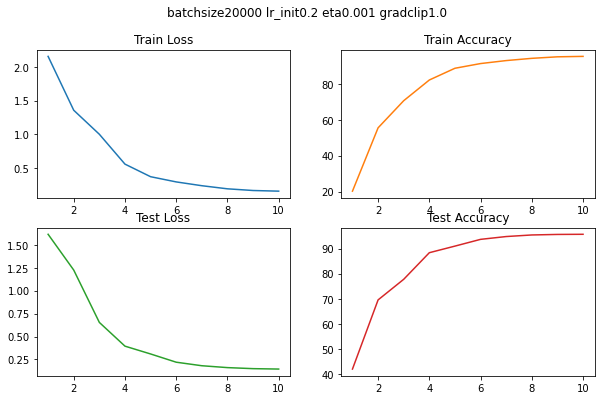

95.71

In [23]:
# LAMB, learning rate decay (2nd)
args.update(epochs=10, batch_size=20000, lr=0.2, verbose=True, lr_decay_degree=2)
model = ConvNet().to(device)
optimizer = opt.Lamb(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

main(args, optimizer, device, model)

{'epochs': 10, 'batch_size': 20000, 'test_batch_size': 10000, 'lr': 0.05, 'lr_decay_degree': 2, 'momentum': 0.0, 'weight_decay': 0.0, 'eta': 0.001, 'clip': 1.0, 'seed': 1, 'dry_run': False, 'save_model': False, 'verbose': True}
LR is modified to 0.0500


TRAIN epoch1 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch1 Average Loss: 2.2670, Accuracy: 15456/60000 (25.7600%)
Test  epoch1 Average Loss: 2.1068, Accuracy: 4975/10000 (49.7500%)
----------------------------------------------------------------------
LR is modified to 0.0405


TRAIN epoch2 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch2 Average Loss: 1.8915, Accuracy: 34007/60000 (56.6783%)
Test  epoch2 Average Loss: 1.2152, Accuracy: 7101/10000 (71.0100%)
----------------------------------------------------------------------
LR is modified to 0.0320


TRAIN epoch3 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch3 Average Loss: 0.9916, Accuracy: 43479/60000 (72.4650%)
Test  epoch3 Average Loss: 0.6764, Accuracy: 7806/10000 (78.0600%)
----------------------------------------------------------------------
LR is modified to 0.0245


TRAIN epoch4 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch4 Average Loss: 0.7274, Accuracy: 46913/60000 (78.1883%)
Test  epoch4 Average Loss: 0.7580, Accuracy: 8035/10000 (80.3500%)
----------------------------------------------------------------------
LR is modified to 0.0180


TRAIN epoch5 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch5 Average Loss: 0.8049, Accuracy: 48322/60000 (80.5367%)
Test  epoch5 Average Loss: 0.7488, Accuracy: 8285/10000 (82.8500%)
----------------------------------------------------------------------
LR is modified to 0.0125


TRAIN epoch6 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch6 Average Loss: 0.7796, Accuracy: 50188/60000 (83.6467%)
Test  epoch6 Average Loss: 0.6963, Accuracy: 8498/10000 (84.9800%)
----------------------------------------------------------------------
LR is modified to 0.0080


TRAIN epoch7 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch7 Average Loss: 0.7184, Accuracy: 50801/60000 (84.6683%)
Test  epoch7 Average Loss: 0.6295, Accuracy: 8616/10000 (86.1600%)
----------------------------------------------------------------------
LR is modified to 0.0045


TRAIN epoch8 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch8 Average Loss: 0.6551, Accuracy: 51581/60000 (85.9683%)
Test  epoch8 Average Loss: 0.5712, Accuracy: 8680/10000 (86.8000%)
----------------------------------------------------------------------
LR is modified to 0.0020


TRAIN epoch9 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch9 Average Loss: 0.5956, Accuracy: 51872/60000 (86.4533%)
Test  epoch9 Average Loss: 0.5372, Accuracy: 8716/10000 (87.1600%)
----------------------------------------------------------------------
LR is modified to 0.0005


TRAIN epoch10 loss?.??? acc?.???:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch10 Average Loss: 0.5681, Accuracy: 52040/60000 (86.7333%)
Test  epoch10 Average Loss: 0.5223, Accuracy: 8756/10000 (87.5600%)
----------------------------------------------------------------------
Training Time Lapse: 86.8649 seconds



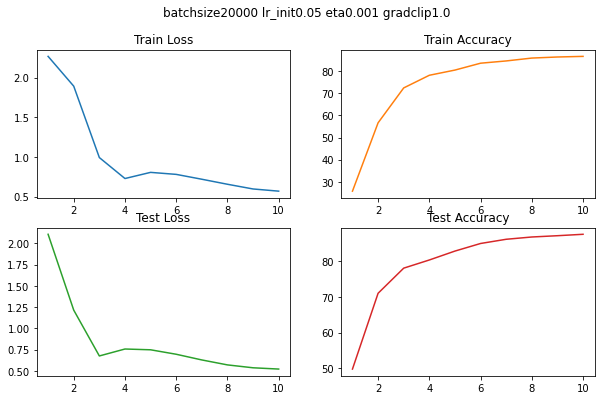

87.56

In [28]:
# NovoGrad, learning rate decay (2nd)
args.update(epochs=10, batch_size=20000, lr=0.05, verbose=True, lr_decay_degree=2)
model = ConvNet().to(device)
optimizer = opt.NovoGrad(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

main(args, optimizer, device, model)